# Predictive Analysis of Diabetes Dataset


## Introduction

Diabetes is a chronic health condition characterized by high blood glucose levels due to insufficient insulin production, resulting in glucose staying in the circulatory system and not reaching cells, leading to heart, vision, and kidney issues. Insulin is a hormone released by the pancreas which aids glucose in reaching cells for energy thus lowering blood glucose levels. There are three main types of diabetes. Type 1 diabetes is an autoimmune reaction that disrupts insulin production, can be diagnosed at any age and requires daily insulin for survival. Type 2 diabetea is a condition characterized by high glucose levels due to the body's inadequate use of insulin, typically develops in adults and can be prevented or delayed through a healthy lifestyle. Gestational diabetes is a condition that develops during pregnancy and typically recovers after a baby's birth, increases the likelihood of developing type 2 diabetes later in life. 

The Centers for Disease Control reports that over 34 million US citizens have diabetes, with 1 in 5 unaware of their condition as of 2020. Through our predictive analysis we hope to gain a better understanding of this prevalent health condition and ultimately answer the following question:

**Question**: Can we use diagnostic measurements including plasma glucose concentration, blood presssure, body mass index, the diabetes pedigree function, and age to predict whether a patient has diabetes?

**Our Dataset**: The dataset we have selected is sourced from a study performed by Johns Hopkins University for the National Institue of Diabetes and Digestive and Kidney Diseases. The original dataset can be found here: https://www.kaggle.com/datasets/mathchi/diabetes-data-set?resource=download. As mentioned at the site, for each patient within the dataset the following data was collected:

- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration after 2 hours of an oral glucose tolerance test
- Blood Pressure: Diastolic blood pressure (mm Hg)
- Skin Thickness: Triceps skin fold thickness (mm)
- Insulin: 2-hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg / (height in m)^2)
- Diabetes Pedigree Function: Diabetes pedigree function
- Age: Age (years)
- Outcome: class variable (0 or 1 where 1 indicates a patient has diabetes)

The diabetes pedigree function estimates the likelihood of diabetes depending on the subject’s age and diabetic family history, which are primary risk factors for diabetes. The oral glucose tolerance test is a diagnostic tool used to screen for type 2 and gestational diabetes by measuring the body's response to glucose.

## Methods

We will be using the K-nearest neighbour (knn) classification method to predict the outcome *Diabetes*, which takes values 0 (negative/non-diabetic) or 1 (positive). Among the 8 columns other than the outcome column, we chose *Pregnancies*, *Glucose*, *Insulin*, *BMI*, *Diabetes Predigree Function*, *Blood Pressure*, and *Age* as the predictors based on our preliminary research as described in the introduction section. 

The whole dataset was scaled and centred before splitting into 75\% training and 25\% testing datasets. For the training data, the knn model was fitted using Euclidean distance. The number of nearest neighbours, $k$, was yet to be determined through 5-fold cross validation, in which the training data were divided equally into 5 subsets, and each subset was used as the validation dataset while the other four were used to fit the model with different $k$. The value of $k$ was then optimized using the average validation **recall** among the 5 validation datasets. We used recall (fraction of positive that are predicted by the model) as our evaluation metrics because our model targets to detect as much diabetes patients as possible, while false positive results are acceptable as they could be handeled by follow-up treatment procedures.

The results were visuallized using a table of the numbers of True/Predicted positive and negative cases, which looks like the one below:

|  | Predicted Positive | Predicted Negative |
| --- | --- | --- |
| **True Positive** | ... | ... |
| **True Negative** | ... | ... |

## Results

### Preliminary exploratory data analysis

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(ggplot2)
install.packages("themis")
library(themis)

set.seed(100);

diabetes_data <- read_csv("https://raw.githubusercontent.com/ktran003/dsci_100_project/main/diabetes.csv")

diabetes_data <- diabetes_data |> mutate(Outcome = as_factor(Outcome)) |>
                mutate(Outcome = fct_recode(Outcome, "Non-Diabetic" = "0", "Diabetic" = "1"))

head(diabetes_data)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,0,33.6,0.627,50,Diabetic
1,85,66,29,0,26.6,0.351,31,Non-Diabetic
8,183,64,0,0,23.3,0.672,32,Diabetic
1,89,66,23,94,28.1,0.167,21,Non-Diabetic
0,137,40,35,168,43.1,2.288,33,Diabetic
5,116,74,0,0,25.6,0.201,30,Non-Diabetic


In this dataset:

- Each variable forms a column.
- Each observation forms a row.
- Each type of observational unit forms a table.

Therefore, as each row represents an individual's data on each variable, the dataset is already tidy and requires no further wrangling.

In [2]:
#splitting dataframe into training, testing datasets
set.seed(100);
diabetes_split <- initial_split(diabetes_data, prop = 0.75, strata = Outcome)

diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)

To begin our exploratory data analysis, we have derived some summary statistics for each of the predictor values in our dataset. The following tables display the mean of each predictor factor, grouped-by the non-diabetic and diabetic patients in the dataset.

In [3]:
#summarizing to get mean of each predictor + total no. of rows per class (diabetic vs non-diabetic women)
set.seed(100);
diabetes_summary <- diabetes_train |>
                    group_by(Outcome) |>
                    summarize(mean_Pregnancies = mean(Pregnancies), mean_Glucose = mean(Glucose),
                              mean_BloodPressure = mean(BloodPressure), mean_SkinThickness = mean(SkinThickness),
                              mean_Insulin = mean(Insulin), mean_BMI = mean(BMI), 
                              mean_DiabetesPedigreeFunction = mean(DiabetesPedigreeFunction), mean_Age = mean(Age),
                              n_count = n(), missing_data_count = sum(is.na(diabetes_train)))

diabetes_summary

Outcome,mean_Pregnancies,mean_Glucose,mean_BloodPressure,mean_SkinThickness,mean_Insulin,mean_BMI,mean_DiabetesPedigreeFunction,mean_Age,n_count,missing_data_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
Non-Diabetic,3.293333,109.5120,68.67200,19.57333,66.20533,30.30347,0.4314507,31.60533,375,0
Diabetic,4.870647,142.1144,70.72139,22.65174,108.43781,35.20149,0.5720945,37.08955,201,0


Evidently, there appears to be a significant difference in the number of diabetic vs non-diabetic data points within our dataset. As a result, we must perform rebalancing to avoid issues with our classification model.

In [4]:
set.seed(100)
upsample_recipe <- recipe(Outcome ~ ., data = diabetes_train) |>
                   step_upsample(Outcome, over_ratio = 1, skip = FALSE) |>
                    prep()

diabetes_ups_train <- bake(upsample_recipe, diabetes_train)

diabetes_ups_train |> group_by(Outcome) |> summarize(n = n())

Outcome,n
<fct>,<int>
Non-Diabetic,375
Diabetic,375


Furthermore, the visualizations below compare the distribution of the predictors we will be using for our analysis.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


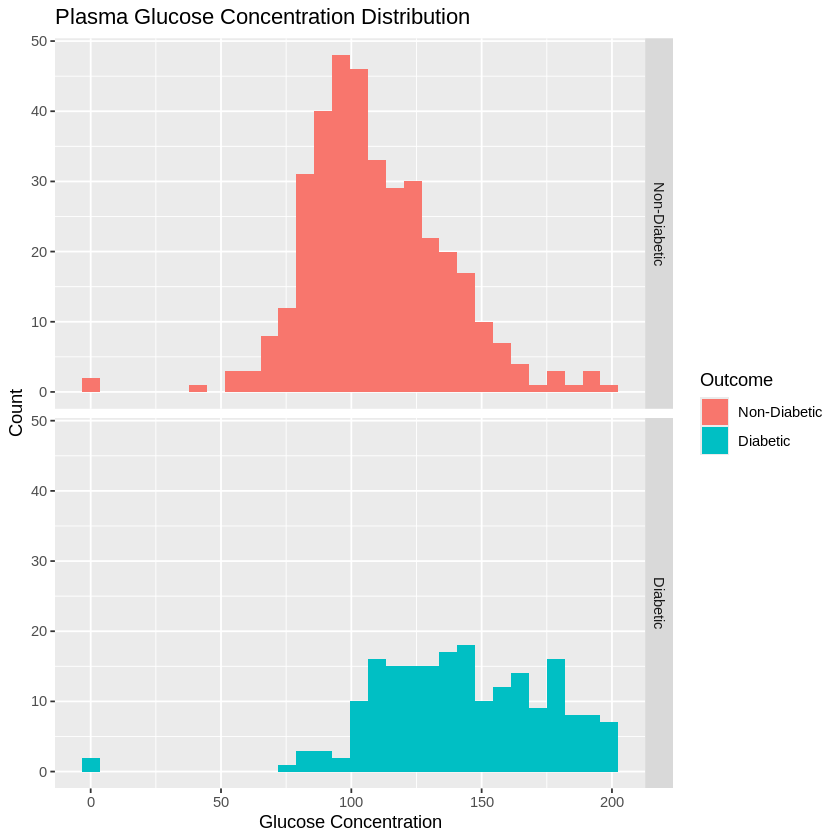

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


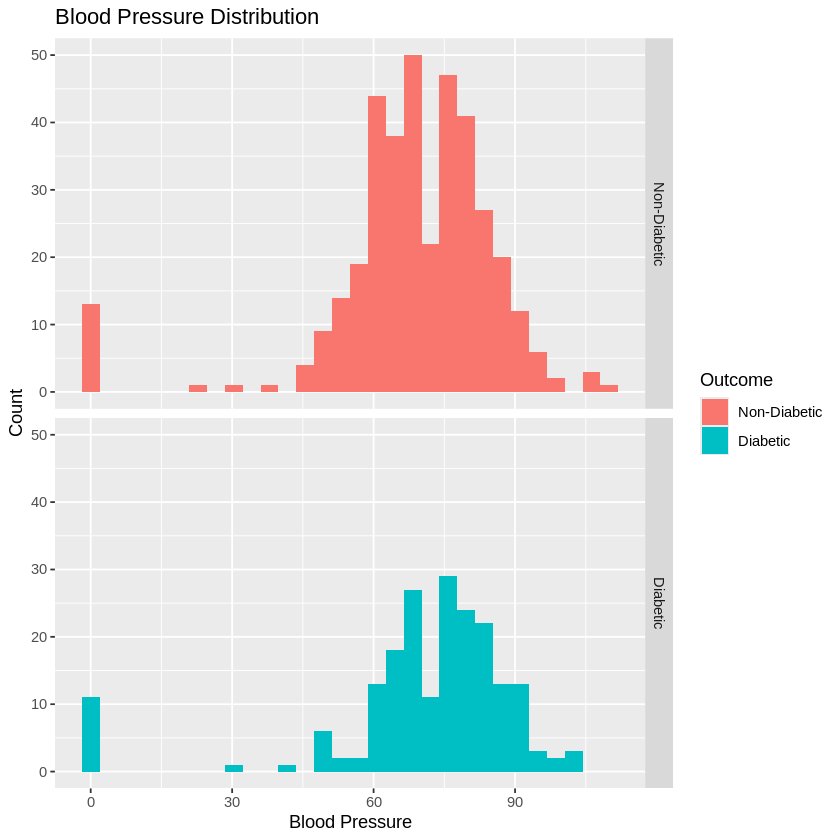

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


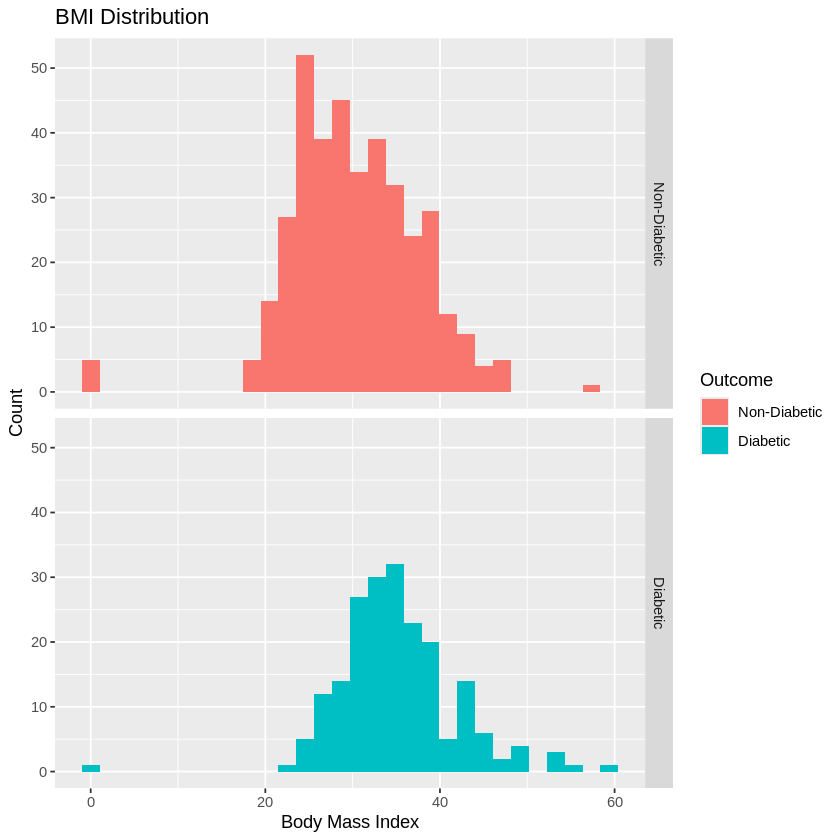

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


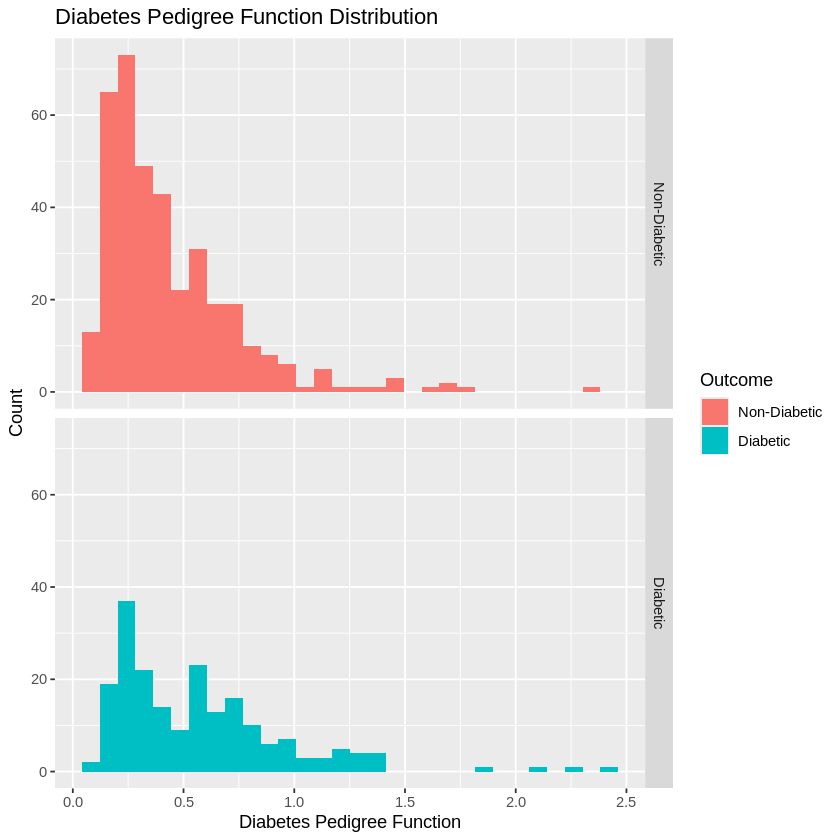

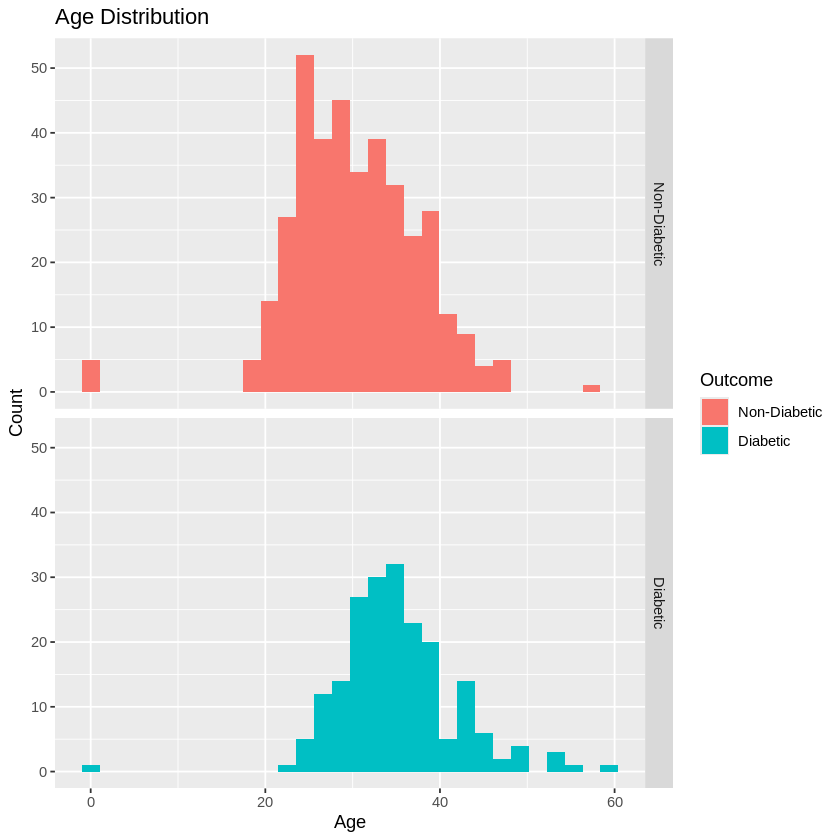

In [5]:
set.seed(100);
# Histograms for numerical predictors against the outcome
numerical_predictors <- c("Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age")

# Glucose
glucose_distribution <- ggplot(diabetes_train, aes(x = Glucose, fill = as_factor(Outcome))) + geom_histogram() +
                            facet_grid(rows = vars(Outcome)) + labs(x = "Glucose Concentration", y = "Count", fill = "Outcome") +
                            ggtitle("Plasma Glucose Concentration Distribution")
glucose_distribution

# Blood Pressure
bp_distribution <- ggplot(diabetes_train, aes(x = BloodPressure, fill = as_factor(Outcome))) + geom_histogram() +
                            facet_grid(rows = vars(Outcome)) + labs(x = "Blood Pressure", y = "Count", fill = "Outcome") +
                            ggtitle("Blood Pressure Distribution")
bp_distribution

#Body Mass Index
bmi_distribution <- ggplot(diabetes_train, aes(x = BMI, fill = as_factor(Outcome))) + geom_histogram() +
                            facet_grid(rows = vars(Outcome)) + labs(x = "Body Mass Index", y = "Count", fill = "Outcome") +
                            ggtitle("BMI Distribution")
bmi_distribution

# Diabetes Pedigree Function
dpf_distribution <- ggplot(diabetes_train, aes(x = DiabetesPedigreeFunction, fill = as_factor(Outcome))) + geom_histogram() +
                            facet_grid(rows = vars(Outcome)) + labs(x = "Diabetes Pedigree Function", y = "Count", fill = "Outcome") +
                            ggtitle("Diabetes Pedigree Function Distribution")
dpf_distribution

# Age
age_distribution <- ggplot(diabetes_train, aes(x = BMI, fill = as_factor(Outcome))) + geom_histogram() +
                            facet_grid(rows = vars(Outcome)) + labs(x = "Age", y = "Count", fill = "Outcome") +
                            ggtitle("Age Distribution")
age_distribution

### Data analysis

In [14]:
set.seed(1000)
names <- colnames(diabetes_train |> select(-Outcome))

example_formula <- paste("Outcome", "~", paste(names, collapse="+"))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(),
                     model_string = character(),
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
diabetes_vfold <- vfold_cv(diabetes_train, v = 5, strata = Outcome)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Outcome", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        diabetes_recipe <- recipe(as.formula(model_string),
                                data = diabetes_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the K-NN classifier with these predictors,
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(diabetes_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = diabetes_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
        

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
      add_row(size = i,
              model_string = models[[jstar]],
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

In [15]:
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Outcome ~ Glucose,0.7135082
2,Outcome ~ Glucose+DiabetesPedigreeFunction,0.7710345
3,Outcome ~ Glucose+DiabetesPedigreeFunction+BMI,0.7675262
4,Outcome ~ Glucose+DiabetesPedigreeFunction+BMI+Age,0.7829985
5,Outcome ~ Glucose+DiabetesPedigreeFunction+BMI+Age+Pregnancies,0.7673613
6,Outcome ~ Glucose+DiabetesPedigreeFunction+BMI+Age+Pregnancies+BloodPressure,0.7587106
7,Outcome ~ Glucose+DiabetesPedigreeFunction+BMI+Age+Pregnancies+BloodPressure+Insulin,0.7552624
8,Outcome ~ Glucose+DiabetesPedigreeFunction+BMI+Age+Pregnancies+BloodPressure+Insulin+SkinThickness,0.7429685


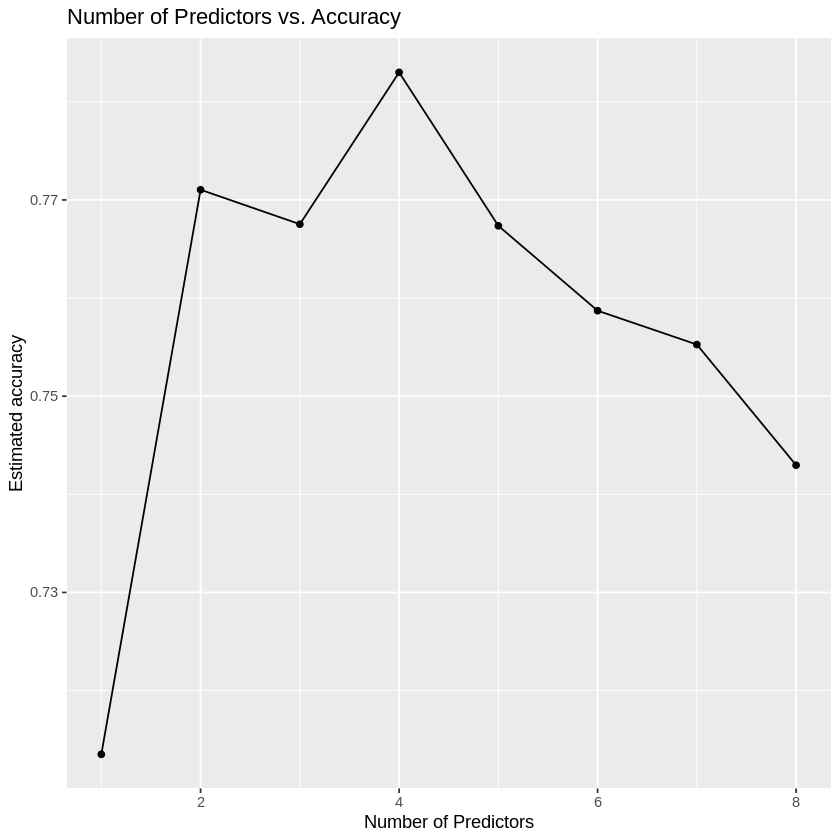

In [8]:
predictor_accuracy_graph <- ggplot(accuracies, aes(size, accuracy)) + geom_point() + geom_line() +
    labs(x="Number of Predictors", y="Estimated accuracy") + ggtitle("Number of Predictors vs. Accuracy")

predictor_accuracy_graph

Through Forward Selection, we determined which predictors to incorporate into the analysis. This method prioritizes variables based on their significance to the outcome, adding them sequentially in order of importance:

Glucose, Age, BMI, Insulin, Blood Pressure, Diabetes Pedigree Function, Skin Thickness, Pregnancies. 

the model above visualizes the accuracy versus the number of predictors in the model. You can see that as predictors are added, the estimated accuracy increases or decreases as the model attempts to tune the number of neighbors to account for the extra noise. In order to pick the right model from the sequence, we will choose 5 predictors to balance high accuracy and model simplicity given by model of size vs accuracy. Therefore, the columns we will choose to include in our analysis report will include the top 5 choices given by the forward selection: Glucose, Diabetes Pedigree Function, BMI, Age.

In [20]:
model_string_best <- accuracies |>
    filter(accuracy==max(accuracy)) |>
    select(model_string) |>
    unlist()

diabetes_recipe_best <- recipe(as.formula(model_string_best),
                                data = diabetes_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

best_k <- workflow() |>
    add_recipe(diabetes_recipe_best) |>
    add_model(knn_spec) |>
    tune_grid(resamples = diabetes_vfold, grid = 10) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    filter(mean == max(mean)) |>
    select(neighbors) |>
    head(1) |>
    unlist()

knn_best_spec<- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
     set_engine("kknn") |>
     set_mode("classification")

knn_best_fit <- workflow() |>
    add_model(knn_best_spec) |>
    add_recipe(diabetes_recipe_best) |>
    fit(diabetes_train)

diabetes_predictions <- knn_best_fit |>
    predict(diabetes_test) |>
    bind_cols(diabetes_test)

diabetes_metrics <- diabetes_predictions |>
    metrics(truth = Outcome, estimate= .pred_class)

diabetes_metrics

diabetes_conf_mat <- diabetes_predictions |>
    conf_mat(truth = Outcome, estimate= .pred_class)

diabetes_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7395833
kap,binary,0.4020182


              Truth
Prediction     Non-Diabetic Diabetic
  Non-Diabetic          106       31
  Diabetic               19       36

### Visualization of analysis

## Expected outcomes and significance


Based on our background research, we expect to find that our study will demonstrate that these diagnostic measurements (plasma glucose concentration, body mass index, diabetes pedigree, blood pressure, and age) can be used to effectively predict whether a patient has diabetes. This has potentially significant impacts as the ability to predict whether a patient has diabetes can prevent or delay serious complications. In addition, those who were prediagnosed with type 2 diabetes can prevent or reduce the risk of other diseases that are caused by diabetes such as heart disease, kidney disease, and nerve damage through moderate lifestyle changes.

Our analysis and the impact of our finding will likely prompt many additional questions that require future exploration. This includes

- What social and behavioural factors can be used to predict whether a patient has diabetes? (e.g. exercise habits, eating habits, social circles)
- What are the differences in the predictive factors for diabetes in men and women?
- Do any of the diagnostic measurements that we considered have a greater relative predictive strength for diabetes? What is the most influential factor?


## Resources/Citations

https://www.niddk.nih.gov/health-information/diabetes/overview/what-is-diabetes

https://www.cdc.gov/diabetes/basics/diabetes.html

https://openventio.org/wp-content/uploads/Determinants-of-Gestational-Diabetes-Pedigree-Function-for-Pima-Indian-Females-IMOJ-6-121.pdf

https://www.mayoclinic.org/tests-procedures/glucose-tolerance-test/about/pac-20394296

https://www.mclaren.org/lansing/news/early-diabetes-detection-can-prevent-serious-compl-3074#:~:text=Therefore%2C%20it's%20crucial%20to%20keep,kidney%20disease%2C%22%20Sobleskey%20said